In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt


In [3]:
# Define directories
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/val'

# Image dimensions
img_width, img_height = 224, 224  # ResNet50 expects 224x224 images
batch_size = 32
epochs = 25

In [4]:
# Data augmentation and preprocessing for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.15  # Split data into training and validation sets
)

# Data preprocessing for test data
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',  # Use RGB images
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',  # Use RGB images
    class_mode='binary',
    subset='validation',
    shuffle=True  # Important for evaluation metrics
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='rgb',  # Use RGB images
    class_mode='binary',
    shuffle=False  # Important for evaluation metrics
)

Found 6800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [5]:
# Load the ResNet-50 model without the top layer
input_tensor = Input(shape=(img_width, img_height, 3))  # ResNet50 expects 3-channel input
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and saving the best model
callbacks = [
    ModelCheckpoint('ResNet.keras', monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
]

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [6]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/25
212/212 [==============================] - 661s 3s/step - loss: 0.4744 - accuracy: 0.7942 - val_loss: 0.6257 - val_accuracy: 0.6436
Epoch 2/25
212/212 [==============================] - 653s 3s/step - loss: 0.2916 - accuracy: 0.8932 - val_loss: 0.4113 - val_accuracy: 0.8260
Epoch 3/25
212/212 [==============================] - 650s 3s/step - loss: 0.2604 - accuracy: 0.9056 - val_loss: 0.4828 - val_accuracy: 0.7483
Epoch 4/25
212/212 [==============================] - 650s 3s/step - loss: 0.2572 - accuracy: 0.9072 - val_loss: 0.4427 - val_accuracy: 0.7804
Epoch 5/25
212/212 [==============================] - 653s 3s/step - loss: 0.2569 - accuracy: 0.9048 - val_loss: 0.4064 - val_accuracy: 0.8041
Epoch 6/25
212/212 [==============================] - 650s 3s/step - loss: 0.2443 - accuracy: 0.9056 - val_loss: 0.5310 - val_accuracy: 0.6917
Epoch 7/25
212/212 [==============================] - 650s 3s/step - loss: 0.2331 - accuracy: 0.9028 - val_loss: 0.4294 - val_accuracy: 0.7720

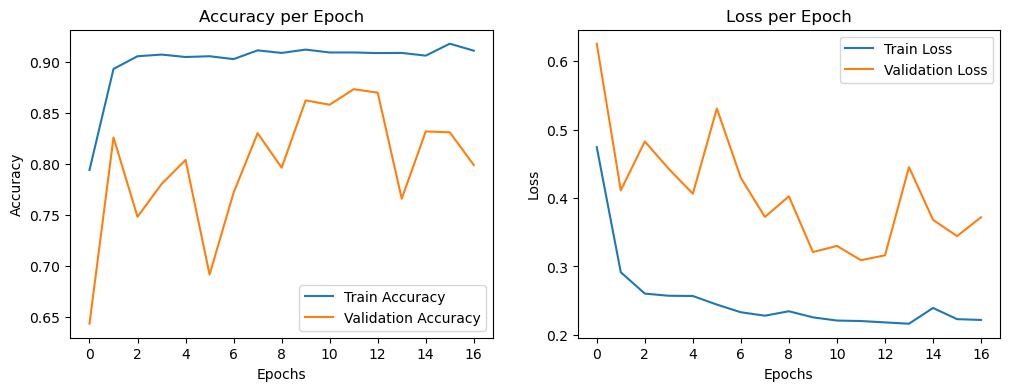

In [7]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [8]:
# Save the model
model.save('ResNet50.keras')

# Load the best model
best_model = load_model('ResNet50.keras')

# Predict on the test set
predictions = best_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predictions = (predictions > 0.5).astype(int).reshape(-1)

true_labels = test_generator.classes

print('Confusion Matrix')
print(confusion_matrix(true_labels, predictions))

print('Classification Report')
print(classification_report(true_labels, predictions, target_names=['NORMAL', 'PNEUMONIA']))


1/1 [==============================] - 3s 3s/step
Confusion Matrix
[[2 6]
 [0 8]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       1.00      0.25      0.40         8
   PNEUMONIA       0.57      1.00      0.73         8

    accuracy                           0.62        16
   macro avg       0.79      0.62      0.56        16
weighted avg       0.79      0.62      0.56        16

